In [1]:
import torch
import matplotlib.pyplot as plt

import numpy as np
# from sys import path
# path.insert(0,r"C:\Users\u0150568\OneDrive - KU Leuven\Code\deepxde")
import deepxde as dde
import BVP_function as bvp
import os

import seaborn as sns
sns.set_style("whitegrid") # better looking plots

print("Using GPU:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

from importlib import reload
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white" # Set figure background to white for notebook with dark mode

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Using GPU: False


In [2]:
# reload(bvp)

lmbd = torch.tensor(1.0)
mu = torch.tensor(0.5)

lmbd_trainable = dde.Variable(lmbd - 0.1)
mu_trainable = dde.Variable(mu + 0.1)
Q = 4.0

domain = np.array([[0.0, 1.0], [0.0, 1.0]])
geom = dde.geometry.Rectangle([0, 0], [1, 1])

phy_params = {'lmbd': lmbd, 'mu': mu, 'Q': Q}
phy_params_trainable = {'lmbd': lmbd_trainable, 'mu': mu_trainable, 'Q': Q}

#net parameters
net_type = ['Unet','USnet'][1]
n_layers = 4
size_layers = 50
activation = ['tanh','ReLU','Sigmoid'][0]

#loss parameters
loss_type = ['pde','energy'][0] #the energy loss appears to crash LBFGS and provide less accurate results with Adam. PDE loss is therefore used in the following
num_domain = 50**2
train_distribution = ['uniform','pseudo','LHS','Halton','Hammersley','Sobol'][4]

#boundary conditions
bc_type = ['soft','hard'][1]
num_boundary = 50

#optimizer
optimizers = ["adam","L-BFGS"]
learning_rates = [1e-3,None]
iterations = [3000,None]

config = {'net_type':net_type,'n_layers':n_layers,'size_layers':size_layers,'activation':activation,
        'loss_type':loss_type,'num_domain':num_domain,'train_distribution':train_distribution,
        'bc_type':bc_type,'num_boundary':num_boundary,
        'optimizers':optimizers,'learning_rates':learning_rates,'iterations':iterations}  

net_exact = bvp.set_exact_solution(net_type, phy_params,lib='np')

net = dde.nn.PFNN([2, [20]*5, [20]*5, [20]*5,[20]*5, 5], "tanh", "Glorot normal")
# net = dde.nn.FNN([2, 50 ,50 ,50 ,50 , 5], "sin", "Glorot normal")
net_wrong_elasticity,total_loss,bc,pde_net,energy_net,mat_net = bvp.net_setup(net,net_type,bc_type,loss_type,geom,phy_params,phy_params_trainable)

c:\Users\u0150568\.conda\envs\pinn-cm\lib\site-packages\deepxde\backend\pytorch\tensor.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(initial_value, dtype=dtype, requires_grad=True)


In [3]:
def generate_measures(domain, num_points, func, noise=0.0, seed=None):
    X = np.linspace(domain[0][0], domain[0][1], int(np.sqrt(num_points)))
    Y = np.linspace(domain[1][0], domain[1][1], int(np.sqrt(num_points)))
    Xgrid, Ygrid = np.meshgrid(X, Y)
    X_obs = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))
    Yexact = func(X_obs)
    Y_obs = Yexact# + noise * np.random.randn(*Yexact.shape)
    return X_obs, Y_obs

# generate training data
S_exact = lambda X: bvp.S_exact(X,phy_params)
U_exact = lambda X: bvp.U_exact(X,phy_params)

X_obs, U_obs = generate_measures(domain, 1000, U_exact, noise=0.0)
X_obs, S_obs = generate_measures(domain, 1000, S_exact, noise=0.0)


observe_Ux = dde.PointSetBC(X_obs, U_obs[:, 0:1], component=0)
observe_Uy = dde.PointSetBC(X_obs, U_obs[:, 1:2], component=1)

observe_Sx = dde.PointSetBC(X_obs, S_obs[0].reshape(-1, 1), component=2)
observe_Sy = dde.PointSetBC(X_obs, S_obs[1].reshape(-1, 1), component=3)
observe_Sxy = dde.PointSetBC(X_obs, S_obs[2].reshape(-1, 1), component=4)



# material_behavior = dde.icbc.OperatorBC()
bc += [observe_Ux, observe_Uy]
# bc += [observe_Sx, observe_Sy, observe_Sxy]

# sanity check that BCs are enforced
# U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
# S_output = lambda x, ouput: bvp.S_nn(bvp.E_nn(x,ouput),phy_params_trainable) if config['net_type'] == 'Unet' else (ouput[:,2], ouput[:,3], ouput[:,4]) 

# fig = bvp.plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
# fig = bvp.plot_field(domain,model,output_func=S_output,V_exact=S_exact,plot_diff=True,fields_name="S")

In [4]:
# train U subnetwork on ground truth U


data = dde.data.Function(
    geom,
    U_exact,
    num_train=num_domain,
    num_test=1000,
    train_distribution="uniform"
)

def output_U_train(x,net_output):
    Ux = net_output[:,0]*x[:,1]*(1-x[:,1])
    Uy = net_output[:,1]*x[:,0]*(1-x[:,0])*x[:,1]
    return torch.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1))) 

net_wrong_elasticity.apply_output_transform(output_U_train)



# net_wrong_elasticity.freeze_subnetworks([2,3,4])
model = dde.Model(data, net_wrong_elasticity)

model.compile("adam", lr=1e-3, metrics=["l2 relative error"])#,loss_weights=loss_weights)
# losshistory, train_state = model.train(iterations=2000)

U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
# fig = bvp.plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")


Compiling model...


'compile' took 1.572654 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.56e-01]    [1.58e-01]    [1.01e+00]    
1000      [1.73e-04]    [1.79e-04]    [3.40e-02]    
2000      [4.42e-05]    [4.98e-05]    [1.79e-02]    

Best model at step 2000:
  train loss: 4.42e-05
  test loss: 4.98e-05
  test metric: [1.79e-02]

'train' took 97.491642 s



: 

In [ ]:
def HardBC_USnet(x,net_output):
    lmbd, mu, Q = phy_params["lmbd"], phy_params["mu"], phy_params["Q"]

    Ux = net_output[:,0]*x[:,1]*(1-x[:,1])
    Uy = net_output[:,1]*x[:,0]*(1-x[:,0])*x[:,1]

    Sxx = net_output[:,2]*x[:,0]*(1-x[:,0])
    Syy = net_output[:,3]*(1-x[:,1]) + (lmbd + 2*mu)*Q*torch.sin(torch.pi*x[:,0])
    Sxy = net_output[:,4] 
    return torch.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1),Sxx.reshape(-1,1),Syy.reshape(-1,1),Sxy.reshape(-1,1))) 




net_wrong_elasticity.apply_output_transform(HardBC_USnet)
net_wrong_elasticity.freeze_subnetworks([0,1])


trainable_variables = [lmbd_trainable, mu_trainable]
variable = dde.callbacks.VariableValue(trainable_variables, period=50, filename="elasticity_param.dat")
fname = "saved_model"
loss_weights = [1,1,1,1,1,1,1,1]


data = dde.data.PDE(
    geom,
    total_loss,
    bc,
    num_domain=num_domain,
    num_boundary=num_boundary,z
    num_test= num_domain,
    train_distribution = train_distribution,
    solution=net_exact,
)
model = dde.Model(data, net)

print(f"lambda:{lmbd_trainable} ; mu: {mu_trainable}")

model.compile("adam", lr=1e-2, external_trainable_variables=trainable_variables, metrics=["l2 relative error"])#,loss_weights=loss_weights)
# model.restore(os.path.join(fname,"USnet_lmbd-1.0_mu-0.5-12000.pt"),device=device)
losshistory, train_state = model.train(iterations=5000,display_every=100, callbacks=[variable])

# model.compile("adam", lr=0.001, external_trainable_variables=trainable_variables, metrics=["l2 relative error"])
# losshistory, train_state = model.train(iterations=3000,display_every=1000, callbacks=[variable])

# model.compile("adam", lr=0.0001, external_trainable_variables=trainable_variables, metrics=["l2 relative error"])
# losshistory, train_state = model.train(iterations=5000,display_every=1000, callbacks=[variable])

# # train lbfgs
print(f"lambda:{lmbd_trainable} ; mu: {mu_trainable}")
# model.compile("L-BFGS", external_trainable_variables=trainable_variables, metrics=["l2 relative error"])
# # dde.optimizers.config.set_LBFGS_options(maxiter=5000,maxfun=100 )
# losshistory, train_state = model.train(callbacks=[variable],display_every=100,batch_size=100)
# print(f"lambda:{lmbd_trainable} ; mu: {mu_trainable}")£

lambda:0.2645489275455475 ; mu: 0.7559213042259216
Compiling model...
'compile' took 0.000507 s



Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.28e-01, 1.40e-02, 3.23e-01, 3.06e-05, 5.41e-06]    [7.26e-02, 1.26e-02, 1.47e-01, 3.06e-05, 5.41e-06]    [3.56e-01]    
100       [1.28e-01, 1.44e-02, 3.20e-01, 3.06e-05, 5.41e-06]    [7.25e-02, 1.27e-02, 1.44e-01, 3.06e-05, 5.41e-06]    [3.55e-01]    
200       [1.28e-01, 1.35e-02, 3.15e-01, 3.06e-05, 5.41e-06]    [7.14e-02, 1.19e-02, 1.40e-01, 3.06e-05, 5.41e-06]    [3.54e-01]    
300       [1.27e-01, 1.33e-02, 3.10e-01, 3.06e-05, 5.41e-06]    [7.03e-02, 1.17e-02, 1.34e-01, 3.06e-05, 5.41e-06]    [3.53e-01]    
400       [1.26e-01, 1.30e-02, 3.05e-01, 3.06e-05, 5.41e-06]    [6.92e-02, 1.14e-02, 1.29e-01, 3.06e-05, 5.41e-06]    [3.52e-01]    
500       [1.25e-01, 1.28e-02, 2.99e-01, 3.06e-05, 5.41e-06]    [6.81e-02, 1.11e-02, 1.24e-01, 3.06e-05, 5.41e-06]    [3.50e-01]    
600       [1.24e-01, 1.26e-02, 2.94e-01, 3.06e-05,

: 

In [ ]:
print(f"lambda:{lmbd_trainable} ; mu: {mu_trainable}")

In [163]:
fname = "saved_model"
save_run = True
if save_run:
    model.compile("adam", lr=0.01, external_trainable_variables=trainable_variables, metrics=["l2 relative error"],loss_weights=loss_weights)
    model.train(iterations=0,model_save_path=os.path.join(fname, f"{net_type}_lmbd-{lmbd}_mu-{mu}"))

Compiling model...
'compile' took 0.000404 s

Training model...

12000     [3.31e-05, 3.30e-05, 1.76e-05, 3.25e-07, 2.88e-07]    [2.27e-05, 2.66e-05, 1.07e-05, 3.25e-07, 2.88e-07]    [4.91e-03]    

Best model at step 12000:
  train loss: 8.43e-05
  test loss: 6.05e-05
  test metric: [4.91e-03]

Epoch 12000: saving model to saved_model\USnet_lmbd-1.0_mu-0.5-12000.pt ...

'train' took 0.072018 s



In [134]:
f"{net_type}_lmbd-{lmbd}_mu-{mu}"

'USnet_lmbd-1.0_mu-0.5'

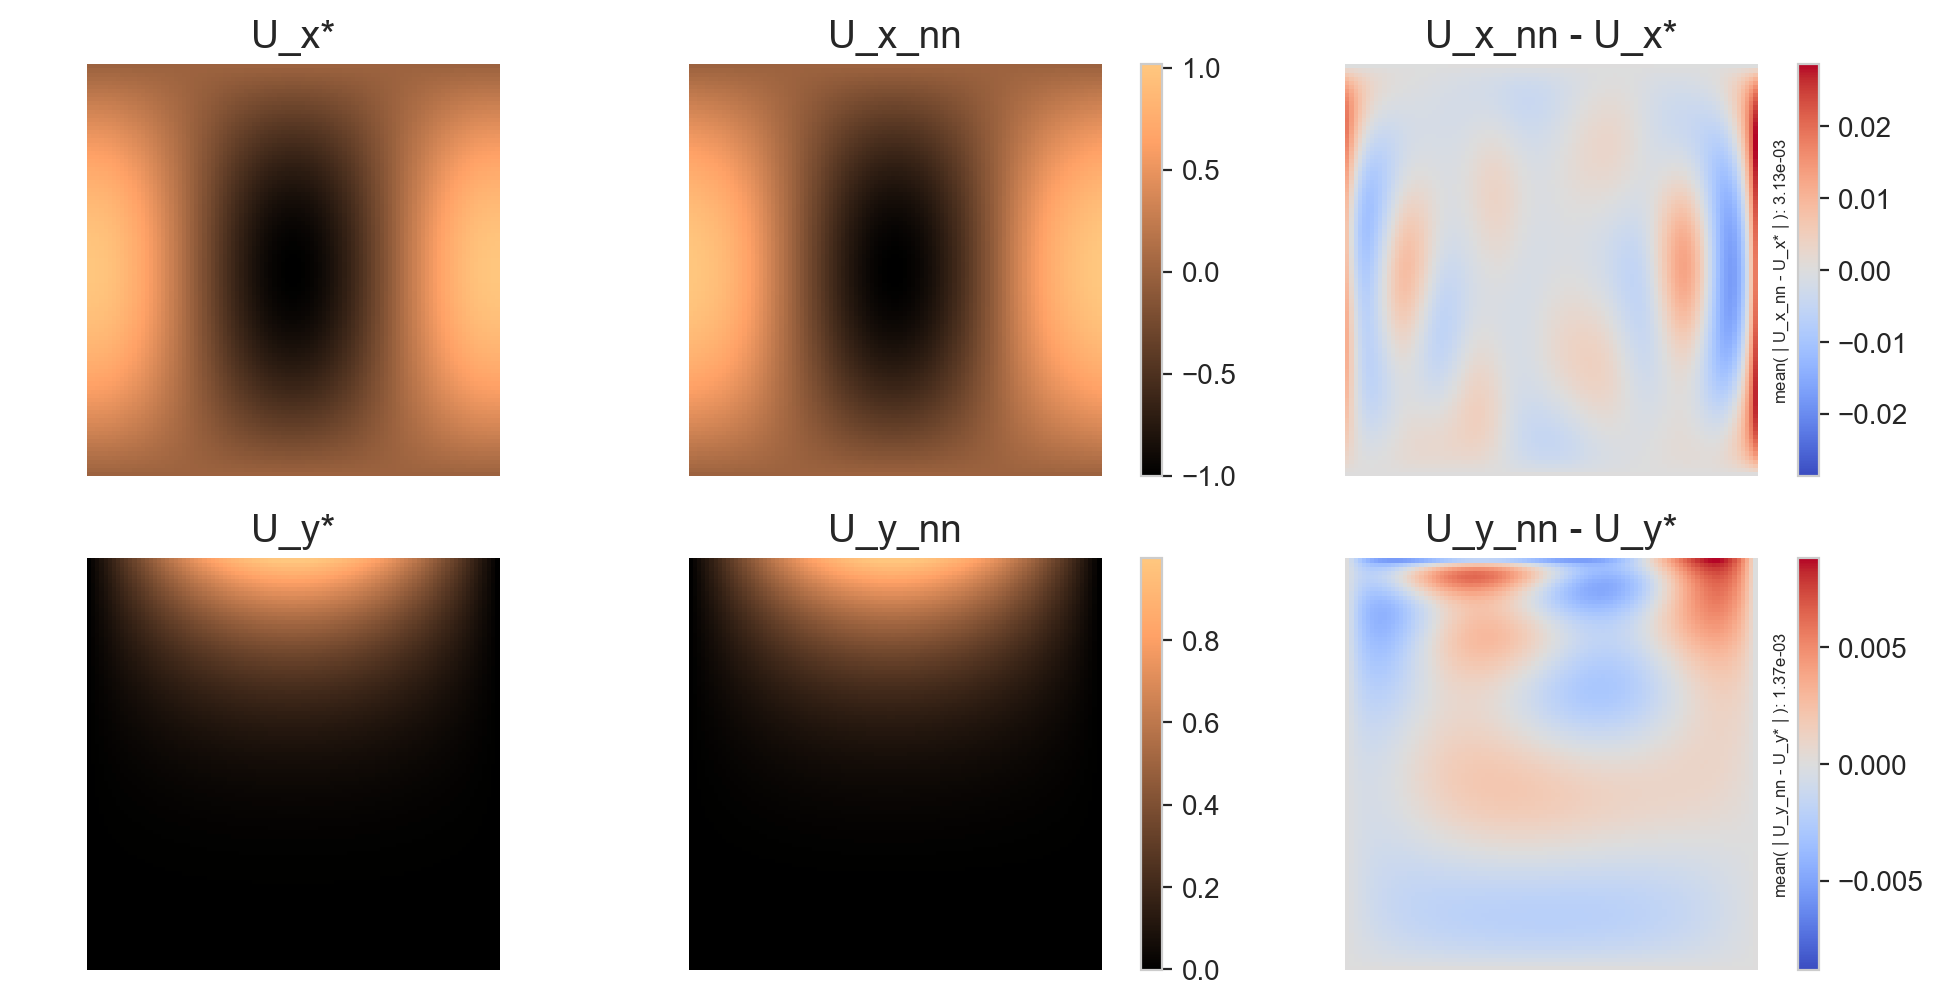

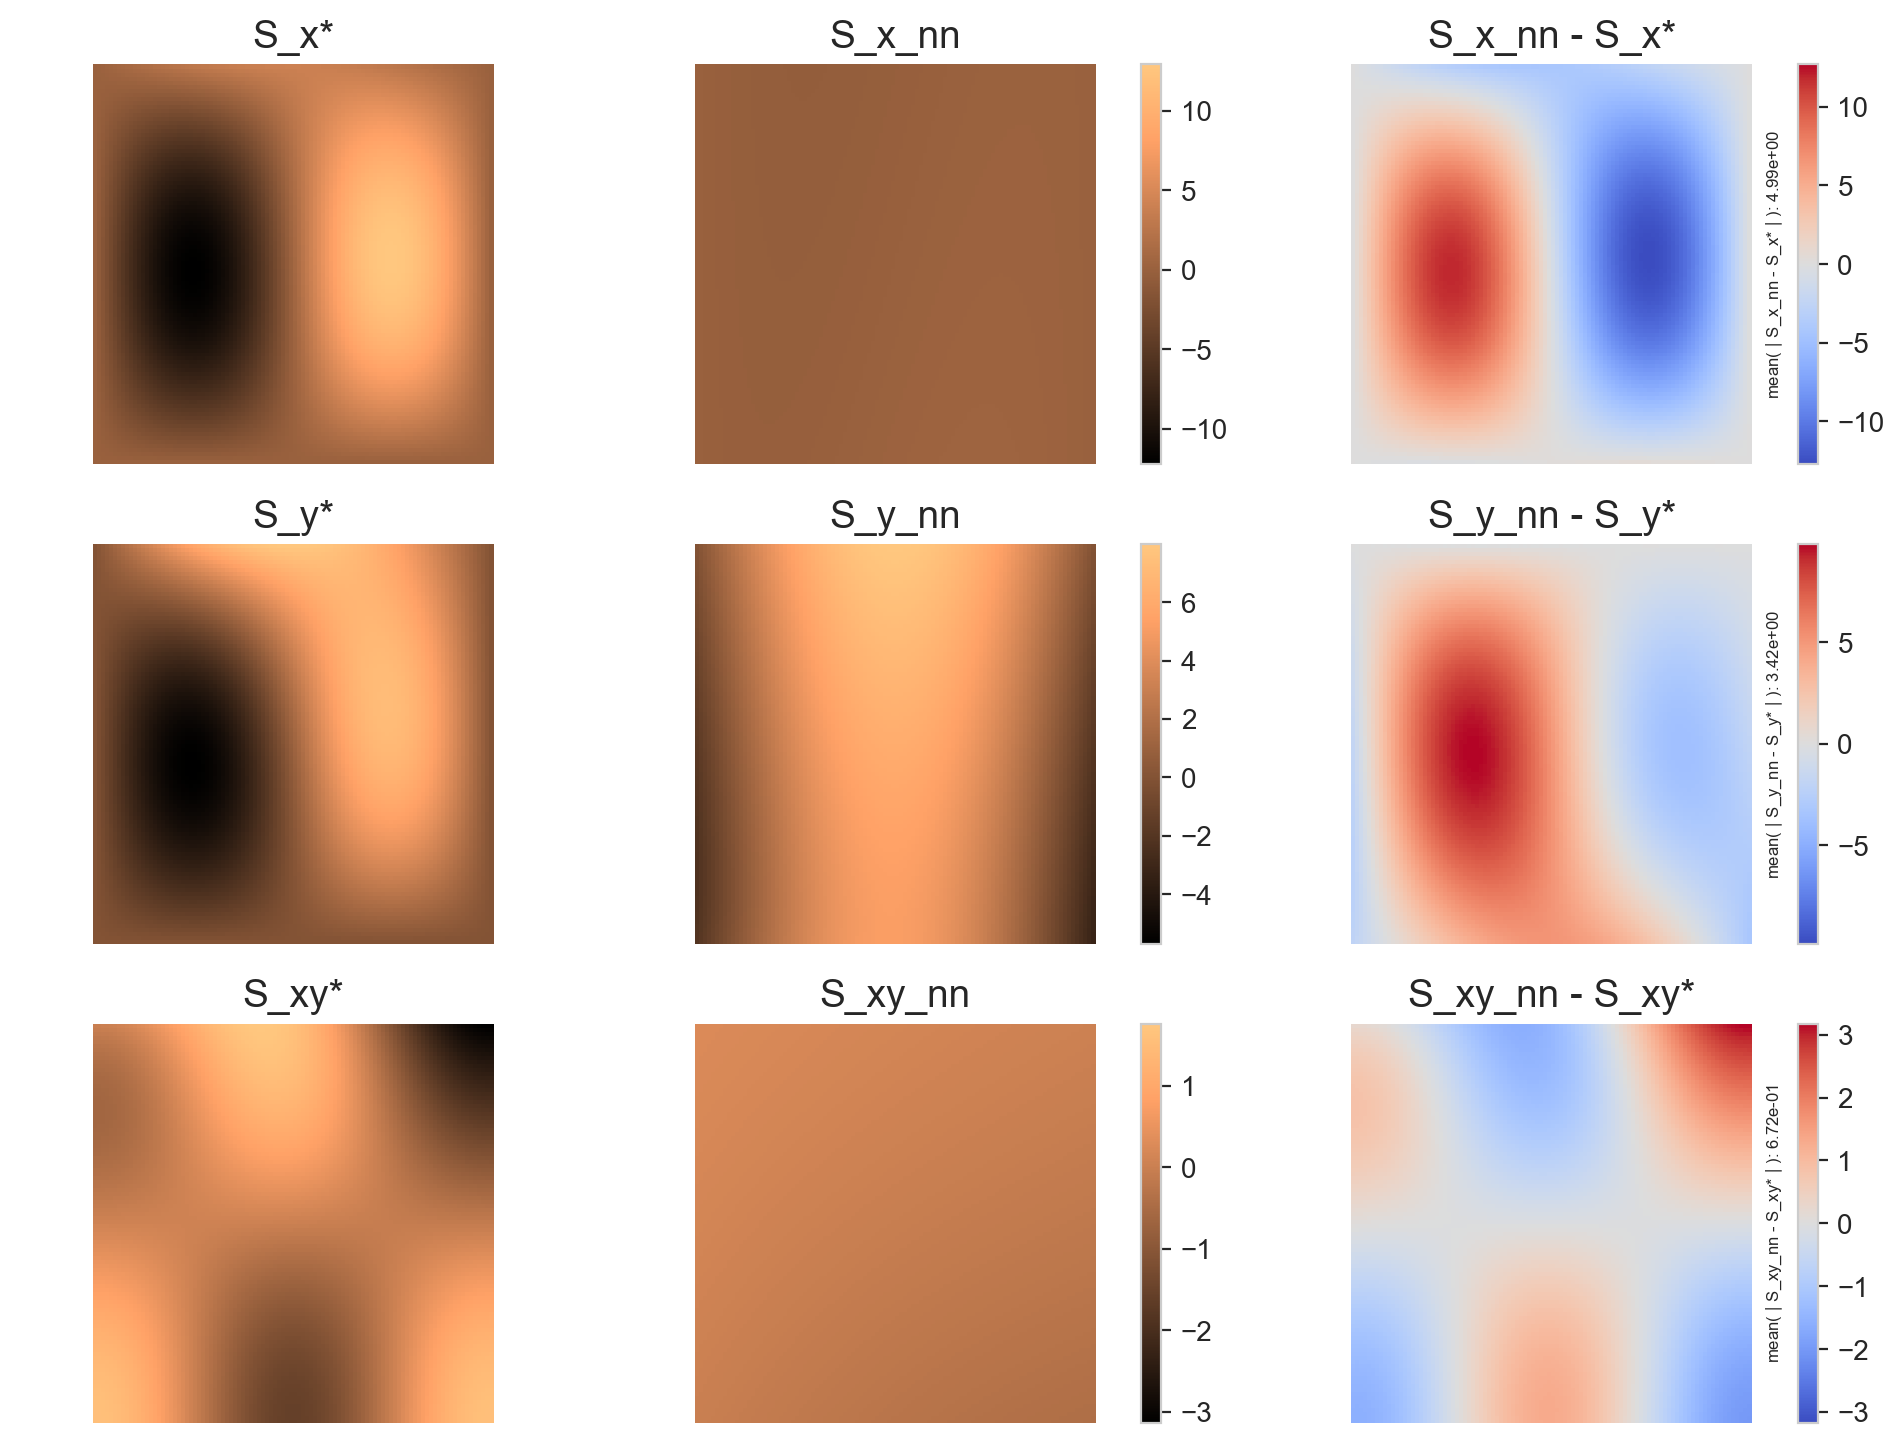

In [14]:
S_exact = lambda X: bvp.S_exact(X,phy_params)
U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
S_output = lambda x, ouput: bvp.S_nn(bvp.E_nn(x,ouput),phy_params_trainable) if config['net_type'] == 'Unet' else (ouput[:,2], ouput[:,3], ouput[:,4]) 

fig = bvp.plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
fig = bvp.plot_field(domain,model,output_func=S_output,V_exact=S_exact,plot_diff=True,fields_name="S")

In [124]:
print(phy_params_trainable)
print(phy_params)

{'lmbd': tensor(0.0581, requires_grad=True), 'mu': tensor(0.9685, requires_grad=True), 'Q': 4.0}
{'lmbd': tensor(1.), 'mu': tensor(0.5000), 'Q': 4.0}
